---
**1. DATA ACQUISITION and VISUALIZATION**

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv(r'/content/drive/MyDrive/NLP/Project/lyrics1.csv', sep = ';', on_bad_lines='skip')
print('The database contains ' + str(len(df)) + ' lyrics')

The database contains 62155 lyrics


In [ ]:
#Union of 3 genres under the genre 'alt rock'
df['ranker_genre'] = np.where(

    (df['ranker_genre'] == 'screamo')|

    (df['ranker_genre'] == 'punk rock')|

    (df['ranker_genre'] == 'heavy metal'), 

    'alt rock', 

    df['ranker_genre']

)
#transform data from having one lyric per row to one song per row
group = ['song', 'year', 'album', 'genre', 'artist', 'ranker_genre']

lyrics_by_song = df.sort_values(group).groupby(group).lyric.apply(' '.join).apply(lambda x: x.lower()).reset_index(name='lyric')
lyrics_by_song["lyric"] = lyrics_by_song['lyric'].str.replace(r'[^\w\s]','')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: The default value of regex will change from True to False in a future version.


In [ ]:
#Some information
print('The database contains ' + str(len(lyrics_by_song)) + ' songs')
print('________________________________')
genres = lyrics_by_song['ranker_genre'].unique()
print('There are ' + str(len(genres)) + ' genres: ')
print(genres)
print('________________________________')
for genre in genres:  
  print(f"Genre {genre.upper()} has {len(lyrics_by_song.loc[lyrics_by_song['ranker_genre']==genre])} songs")
print('________________________________')
hip_hop_songs = lyrics_by_song.loc[lyrics_by_song['ranker_genre']=='Hip Hop']
song=hip_hop_songs.iloc[4030]
print(song)
print('________________________________')
print('The song ' + song['song'] + ' has ' + str(len(song['lyric'])) + ' characters')
print(song['lyric'])
print('________________________________')


The database contains 62155 songs
________________________________
There are 5 genres: 
['alt rock' 'Hip Hop' 'pop' 'rhythm and blues' 'Country']
________________________________
Genre ALT ROCK has 18056 songs
Genre HIP HOP has 6489 songs
Genre POP has 3590 songs
Genre RHYTHM AND BLUES has 6845 songs
Genre COUNTRY has 27175 songs
________________________________
song                                            One Day at a Time
year                                                       2004.0
album                                               Encore (2004)
genre                                                     Hip Hop
artist                                                     Eminem
ranker_genre                                              Hip Hop
lyric           2pac sometimes its hard to wake up in the morn...
Name: 37900, dtype: object
________________________________
The song One Day at a Time has 3739 characters
2pac sometimes its hard to wake up in the morning mind full of dem

In [ ]:
lyrics_by_song.to_csv('/content/drive/MyDrive/NLP/Project/Project/dataset.csv', sep=';')

In [ ]:
lyrics_by_song.groupby('ranker_genre')

---
**2. DATA PROCESSING**

In [ ]:
!pip3 install gensim nltk
import nltk
nltk.download('stopwords')
import numpy as np
import math, scipy
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity 
from scipy import spatial
from gensim.test.utils import datapath
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import codecs
import re
nltk.download('punkt')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/NLP/Project/dataset.csv', sep = ';', on_bad_lines='skip')
df.head()

Mounted at /content/drive


,Unnamed: 0,song,year,album,genre,artist,ranker_genre,lyric
0,0,Bad Girl,2004.0,Rollercoaster (2004),Punk Rock|Oi-Punk,The Adicts,alt rock,theres a rumor youre the talk of the town ther...
1,1,Cheese Tomato Man,2004.0,Rollercoaster (2004),Punk Rock|Oi-Punk,The Adicts,alt rock,cheese tomato flan crazy little man quiche lor...
2,2,Daydreamers Night,2004.0,Rollercoaster (2004),Punk Rock|Oi-Punk,The Adicts,alt rock,shroud cloak veil smoke in camera masquerade i...
3,3,Do It To Me,2004.0,Rollercoaster (2004),Punk Rock|Oi-Punk,The Adicts,alt rock,theres a kid who just found that love is not a...
4,4,Hello Farewell Goodbye,2004.0,Rollercoaster (2004),Punk Rock|Oi-Punk,The Adicts,alt rock,oh we kiss and we fight then we make up all ni...


**Data sampling** \\
Select N songs per genre

In [ ]:
from sklearn.utils import shuffle
from nltk.corpus import stopwords
genres = [
    'alt rock', 'Hip Hop','pop', 'rhythm and blues', 'Country'
]

LYRIC_LEN = 400 # each song has to be  400 characters
N_sampling = 3500 # MAXIMUM: 3514 # number of records to pull from each genre
RANDOM_SEED = 200 # random seed to make results repeatable

df_mini = pd.DataFrame()
test_df = pd.DataFrame()
for genre in genres: # loop over each genre
    subset = df[ # create a subset 
        (df.ranker_genre==genre) &
        (df.lyric.str.len()>LYRIC_LEN)
    ]
    df_mini_ = subset.sample(n=N_sampling, random_state=RANDOM_SEED)
    test_set = subset.drop(df_mini_.index)
    df_mini = df_mini.append(df_mini_) # append subsets to the master sets
  
df_mini = shuffle(df_mini)
print('we are working with',len(df_mini), 'songs for compuational purposes')

we are working with 17500 songs for compuational purposes


In [ ]:
#how long are the lyrics
df['song_length'] = df.apply(lambda row: len(row.lyric), axis=1)
print(df.iloc[df['song_length'].idxmax()].song)
print(df.iloc[df['song_length'].idxmin()])

genres_mean_length = {}
genres_max_length = {}
genres_min_length = {}

for g in genres:
  array_ = np.array((df[df['ranker_genre']==g])['song_length'])
  genres_mean_length[g]=array_.mean()
  genres_max_length[g]=np.amax(array_)
  genres_min_length[g]=np.amin(array_)
print(genres_mean_length)

genres = [
    'alt rock', 'Hip Hop', 'pop', 'rhythm and blues', 'Country'
]
for genre in genres:
  subset = df[ # create a subset 
        (df.ranker_genre==genre)&
        (df.lyric.str.len()>400)
    ]
  print(genre,len(subset),genres_max_length[g])

Mortal Man
Unnamed: 0                               6957
song                         Bring It On Home
year                                   1993.0
album                        Flashback (1993)
genre                          Rock|Hard Rock
artist          Joan Jett and the Blackhearts
ranker_genre                         alt rock
lyric                                     \n 
song_length                                 2
Name: 6957, dtype: object
{'alt rock': 1049.5650753212228, 'Hip Hop': 2736.6520265063955, 'pop': 1271.4796657381617, 'rhythm and blues': 1168.9868517165814, 'Country': 906.6662005519779}
alt rock 17098 5716
Hip Hop 6348 5716
pop 3514 5716
rhythm and blues 6608 5716
Country 26341 5716


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


alt rock mean  1049.5650753212228 variance:  241724.57643514246 mediana 991.0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Hip Hop mean  2736.6520265063955 variance:  1119291.2898082384 mediana 2745.0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


pop mean  1271.4796657381617 variance:  289529.4572347726 mediana 1207.0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


rhythm and blues mean  1168.9868517165814 variance:  359480.948687413 mediana 1062.0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Country mean  906.6662005519779 variance:  148766.56352046836 mediana 835.0


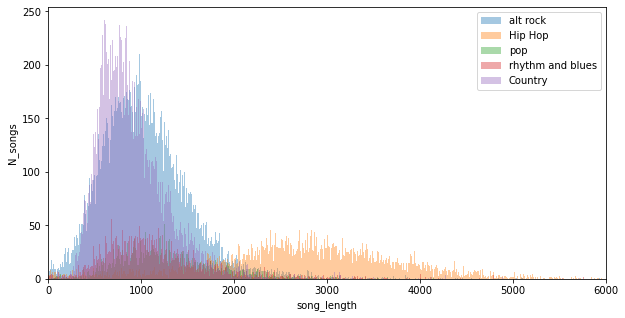

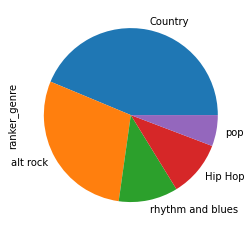

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
#Required if using Jupyter Notebook %matplotlib inline
genres = [
    'alt rock', 'Hip Hop', 'pop', 'rhythm and blues', 'Country'
]

plt.figure(figsize=(10,5))
plt.xlim(0,6000)
plt.xlabel('song_length')
plt.ylabel('N_songs')


for g in genres:
  sns.distplot((df[df['ranker_genre']==g])['song_length'],bins=1000,kde=False)
  print(g, 'mean ',(df[df['ranker_genre']==g])['song_length'].mean(), 'variance: ', (df[df['ranker_genre']==g])['song_length'].var(), 'mediana', (df[df['ranker_genre']==g])['song_length'].median()) 
plt.legend(genres)
plt.show()

df['ranker_genre'].value_counts().plot.pie()

**Build Train_set & Test_set**

In [ ]:
from sklearn.utils import shuffle
from nltk.corpus import stopwords
genres = [
    'alt rock', 'Hip Hop','pop', 'rhythm and blues', 'Country'
]

LYRIC_LEN = 400 # each song has to be  400 characters
N_split = int(N_sampling*0.75) # number of records to pull from each genre for the training set
RANDOM_SEED = 200 # random seed to make results repeatable

train_df = pd.DataFrame()
test_df = pd.DataFrame()
for genre in genres: # loop over each genre
    subset = df_mini[ # create a subset 
        (df_mini.ranker_genre==genre) &
        (df_mini.lyric.str.len()>LYRIC_LEN)
    ]
    train_set = subset.sample(n=N_split, random_state=RANDOM_SEED)
    test_set = subset.drop(train_set.index)
    train_df = train_df.append(train_set) # append subsets to the master sets
    test_df = test_df.append(test_set)
  
train_df_ = shuffle(train_df)
X_train=train_df_.lyric
y_train=train_df_.ranker_genre

test_df_ = shuffle(test_df)
X_test=test_df_.lyric
y_test=test_df_.ranker_genre
print('training sample is:',len(X_train),'and test sample is:',len(X_test))

training sample is: 13125 and test sample is: 4375


**stop words set** 

In [ ]:
#add to stopwords words without apostrophe (shouldn't -> shouldnt)
stopwords_en = stopwords.words('english')
stopwords_en=[word.replace("'", "") for word in stopwords_en]
stopwords_en.append('im')

**Visualization**

In [ ]:
#add to stopwords words without apostrophe (shouldn't -> shouldnt)
stopwords_en = stopwords.words('english')
stopwords_en=[word.replace("'", "") for word in stopwords_en]
stopwords_en.append('im')

n_words=1000
genre_total_df=pd.DataFrame(index=range(n_words*5))
for genre in genres:
  globals()['df_%s' % genre.replace(' ','')] = pd.DataFrame(index=range(n_words))
  print('df_%s' % genre.replace(' ',''))
  vectorizer = CountVectorizer(stop_words=stopwords_en, token_pattern='[A-Za-z]+')
  term_doc_matrix = vectorizer.fit_transform(np.array(train_df.lyric[train_df.ranker_genre==genre])).transpose().toarray()
  vocab = vectorizer.get_feature_names_out()
  vocab = list(vocab)
  # your code ends here
  print('The size of the vocabulary is', len(vocab))
  print('The shape of the term-document matrix is', term_doc_matrix.shape)
  term_doc_matrix_pd = pd.DataFrame(term_doc_matrix, index=vocab, columns=range(term_doc_matrix.shape[1]))
  term_doc_matrix_pd['total'] = term_doc_matrix_pd.sum(axis=1)
  term_doc_matrix_pd = term_doc_matrix_pd.sort_values(by=['total'], ascending=False)
  #print('------------------',genre,'------------------')
  #print(term_doc_matrix_pd['total'][:10])
  (globals()['df_%s' % genre.replace(' ','')])['total']=  (((((term_doc_matrix_pd['total'][:n_words])-(genres_min_length[genre])))/(genres_max_length[genre]-genres_min_length[genre]))).tolist()
  (globals()['df_%s' % genre.replace(' ','')])['word']=term_doc_matrix_pd.index[:n_words].tolist()
  (globals()['df_%s' % genre.replace(' ','')])['genre']= ((((genre.replace(' ',''))+' ')*n_words).split(' '))[:n_words]
  X_train_countvec=term_doc_matrix_pd
genres_total=pd.concat([df_altrock,df_HipHop,df_pop,df_rhythmandblues,df_Country], axis=0)
genres_total=genres_total.sort_values(by=['total'], ascending=False)
genres_total[:10]

df_altrock
The size of the vocabulary is 17399
The shape of the term-document matrix is (17399, 2625)
df_HipHop
The size of the vocabulary is 39326
The shape of the term-document matrix is (39326, 2625)
df_pop
The size of the vocabulary is 10754
The shape of the term-document matrix is (10754, 2625)
df_rhythmandblues
The size of the vocabulary is 11233
The shape of the term-document matrix is (11233, 2625)
df_Country
The size of the vocabulary is 11830
The shape of the term-document matrix is (11830, 2625)


,total,word,genre
0,1.673902,love,rhythmandblues
0,1.233215,like,HipHop
1,1.221740,baby,rhythmandblues
1,0.927012,get,HipHop
2,0.881056,oh,rhythmandblues
0,0.872875,love,pop
3,0.834346,know,rhythmandblues
2,0.791724,got,HipHop
4,0.735197,yeah,rhythmandblues
0,0.733112,love,Country


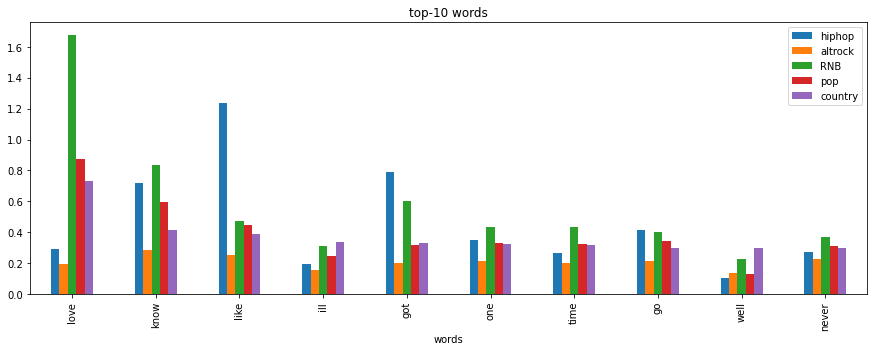

In [ ]:
genres_total=df_Country.sort_values(by=['total'], ascending=False) # redefine for a specific genre
words=(genres_total['word'].unique())[:10]

for genre in genres:
  (globals()['df_%s_words' % genre.replace(' ','')])=(globals()['df_%s' % genre.replace(' ','')])['word'].tolist() #pd to list
  (globals()['df_%s_values' % genre.replace(' ','')])=(globals()['df_%s' % genre.replace(' ','')])['total'].tolist() #pd to list
  (globals()['df_%s_values_common' % genre.replace(' ','')])=[]
  for word in words:
    try:
      (globals()['df_%s_values_common' % genre.replace(' ','')]).append((globals()['df_%s_values' % genre.replace(' ','')])[(globals()['df_%s_words' % genre.replace(' ','')]).index(word)]) #find value for word
    except ValueError:
      (globals()['df_%s_values_common' % genre.replace(' ','')]).append(0)


df_plot = pd.DataFrame({
    'words': words,
    'hiphop': df_HipHop_values_common,
    'altrock': df_altrock_values_common,
    'RNB': df_rhythmandblues_values_common,
    'pop': df_pop_values_common,
    'country': df_Country_values_common,
})


df_plot.plot(x="words", y=["hiphop", "altrock", "RNB", 'pop', 'country'], kind="bar", title= "top-10 words",figsize=(15,5))

**CountVectorizer -> BOW** \\
Docs as vectors, features words count. \\
Removed stopwords, only alphabetic words.

In [ ]:
vectorizer = CountVectorizer(stop_words=stopwords_en, token_pattern='[A-Za-z]+', max_features=2000, strip_accents='ascii', ngram_range=(1,1))
vectorizer_fit=vectorizer.fit(np.array(X_train))
term_doc_matrix = vectorizer_fit.transform(np.array(X_train)).toarray()
vocab = vectorizer.get_feature_names_out()
vocab = list(vocab)

print('The size of the vocabulary is', len(vocab))
print('The shape of the term-document matrix is', term_doc_matrix.shape)

term_doc_matrix_pd = pd.DataFrame(term_doc_matrix, index=range(term_doc_matrix.shape[0]), columns=vocab)
X_train_countvec=term_doc_matrix_pd
#term_doc_matrix_pd

The size of the vocabulary is 2000
The shape of the term-document matrix is (13125, 2000)


Build test set: X_test

In [ ]:
term_doc_matrix = vectorizer_fit.transform(np.array(X_test)).toarray()
vocab = vectorizer.get_feature_names_out()
vocab = list(vocab)

print('The size of the vocabulary is', len(vocab))
print('The shape of the term-document matrix is', term_doc_matrix.shape)
term_doc_matrix_pd = pd.DataFrame(term_doc_matrix, index=range(term_doc_matrix.shape[0]), columns=vocab)
X_test_countvec=term_doc_matrix_pd
#term_doc_matrix_pd

The size of the vocabulary is 2000
The shape of the term-document matrix is (4375, 2000)


**TfIdfVectorizer**

In [ ]:
vectorizer = TfidfVectorizer(stop_words=stopwords_en, token_pattern='[A-Za-z]+', max_features=2000, strip_accents='ascii', ngram_range=(1,1))
vectorizer_fit = vectorizer.fit(np.array(X_train))
term_doc_matrix = vectorizer_fit.transform(np.array(X_train)).toarray()
vocab = vectorizer.get_feature_names_out()
vocab = list(vocab)

print('The size of the vocabulary is', len(vocab))
print('The shape of the term-document matrix is', term_doc_matrix.shape)

term_doc_matrix_pd = pd.DataFrame(term_doc_matrix, index=range(term_doc_matrix.shape[0]), columns=vocab)
X_train_TfIdf=term_doc_matrix_pd
#y_train_TfIdf=train_df.ranker_genre
#term_doc_matrix_pd


The size of the vocabulary is 2000
The shape of the term-document matrix is (13125, 2000)


In [ ]:
term_doc_matrix = vectorizer_fit.transform(np.array(X_test)).toarray()
vocab = vectorizer.get_feature_names_out()
vocab = list(vocab)

print('The size of the vocabulary is', len(vocab))
print('The shape of the term-document matrix is', term_doc_matrix.shape)
term_doc_matrix_pd = pd.DataFrame(term_doc_matrix, index=range(term_doc_matrix.shape[0]), columns=vocab)
X_test_TfIdf = term_doc_matrix_pd
#term_doc_matrix_pd

The size of the vocabulary is 2000
The shape of the term-document matrix is (4375, 2000)


**SVD**

In [ ]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100)
svd_fitted = svd.fit(X_train_TfIdf)
X_train_TfIdf_svd = svd_fitted.transform(X_train_TfIdf)
X_test_TfIdf_svd =svd_fitted.transform(X_test_TfIdf)

In [ ]:
svd.singular_values_

array([24.99941987, 13.07532517, 10.03185477,  9.51904171,  8.46802342,
        8.19323972,  7.80634462,  7.50890915,  7.1826691 ,  7.06037761,
        6.9396955 ,  6.84047218,  6.60450244,  6.53073494,  6.47399287,
        6.42800089,  6.3785056 ,  6.30209351,  6.24751207,  6.18881223,
        6.16115747,  6.13877652,  6.10230149,  6.04577594,  5.97337845,
        5.92905127,  5.91502557,  5.89288133,  5.86432554,  5.82495841,
        5.78689265,  5.71789418,  5.68915503,  5.67732748,  5.63837958,
        5.60536553,  5.5899749 ,  5.56846521,  5.53368615,  5.46699387,
        5.46154877,  5.44471167,  5.41765562,  5.41636017,  5.38547856,
        5.35735613,  5.30868917,  5.29777522,  5.27088325,  5.24298141,
        5.229575  ,  5.21584043,  5.20354905,  5.18072136,  5.15316984,
        5.14306696,  5.1148005 ,  5.08699761,  5.07604298,  5.05817708,
        5.04084035,  5.02542302,  5.00912724,  4.97344457,  4.96599337,
        4.9365279 ,  4.92868793,  4.91993289,  4.87518263,  4.85

**Word2Vec**

In [ ]:
import gensim.downloader as api
google_w2v = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
#encode the song as the average of the term vectors
def w2vmean(l):
    X = np.zeros((300,))
    for x in l:
        if x in google_w2v:
            X += google_w2v[x]
    return X/len(l)

X_train_word2vec = []

for s,c in zip(np.array(X_train),y_train):
    if len(s) != 0:
        X_train_word2vec.append(w2vmean(s))

In [ ]:
#encode the song as the average of the term vectors

X_test_word2vec = []
for s in np.array(X_test):
    if len(s) != 0:
        X_test_word2vec.append(w2vmean(s))

In [ ]:
from gensim.models.word2vec import LineSentence, Word2Vec
sents = " ".join(list(X_train))
text_file = open("/content/drive/MyDrive/NLP/Project/other word docs/unified_lyrics.txt", "w")
#write string to file
text_file.write(sents)
sentences=LineSentence('/content/drive/MyDrive/NLP/Project/other word docs/unified_lyrics.txt')
w2v_lyrics = Word2Vec(sentences, size=300)

In [ ]:
w2v_lyrics.wv['shit'].shape

In [ ]:
#encode the song as the average of the term vectors
def w2vmean_f(l):
    X = np.zeros((300,))
    for x in l:
        if x in w2v_lyrics.wv:
            X += w2v_lyrics.wv[x]
    return X/len(l)

X_train_word2vec_finetuned = []

for s in np.array(X_train):
    if len(s) != 0:
        X_train_word2vec_finetuned.append(w2vmean_f(s))

In [ ]:
#encode the song as the average of the term vectors

X_test_word2vec_finetuned = []
for s in np.array(X_test):
    if len(s) != 0:
        X_test_word2vec_finetuned.append(w2vmean_f(s))

In [ ]:
w2v_medline.wv.most_similar('young')

In [ ]:
print("We kept",len(X_train),"songs from",len(genres_set),"categories:", genres_set)

---
**3. NB prediction**

Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
model=MultinomialNB()

In [ ]:
model.fit(X_train_TfIdf, y_train)
y_pred = model.predict(X_test_TfIdf)
print('Score with :  ',np.mean(y_pred == y_test))

Score with :   0.6553142857142857


In [ ]:
np.mean(y_pred == y_test)

0.6553142857142857

---
**4. Evaluation**

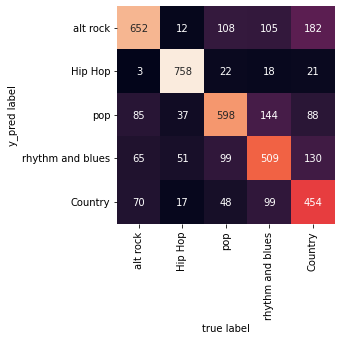

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
try:
  y_pred=y_pred_test
except Exception:
  pass

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(
    mat.T, square=True, annot=True, fmt='d', cbar=False,
    xticklabels=genres, 
    yticklabels=genres
)
plt.xlabel('true label')
plt.ylabel('y_pred label');

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
try:
  y_pred=y_pred_test
except Exception:
  pass
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)

for n,genre in enumerate(genres):
    genre = genre.upper()
    print(genre+'_precision: {}'.format(precision[n]))
    print(genre+'_recall: {}'.format(recall[n]))
    print(genre+'_fscore: {}'.format(fscore[n]))
    print(genre+'_support: {}'.format(support[n]))
    print()

ALT ROCK_precision: 0.615675165250236
ALT ROCK_recall: 0.7451428571428571
ALT ROCK_fscore: 0.6742502585315407
ALT ROCK_support: 875

HIP HOP_precision: 0.9221411192214112
HIP HOP_recall: 0.8662857142857143
HIP HOP_fscore: 0.893341190335887
HIP HOP_support: 875

POP_precision: 0.6281512605042017
POP_recall: 0.6834285714285714
POP_fscore: 0.6546250684181719
POP_support: 875

RHYTHM AND BLUES_precision: 0.5960187353629977
RHYTHM AND BLUES_recall: 0.5817142857142857
RHYTHM AND BLUES_fscore: 0.5887796414112203
RHYTHM AND BLUES_support: 875

COUNTRY_precision: 0.6598837209302325
COUNTRY_recall: 0.5188571428571429
COUNTRY_fscore: 0.5809341010876521
COUNTRY_support: 875



---
**5. Other models**

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.model_selection import validation_curve

In [ ]:
models_names=['Logistic Regression', 'KNN Classifier', 'Decision Tree Classifier', "Neural Network Classifier", "Random Forest Classifier", "Support Vector Machine"]

index_names_=['Logistic Regression','KNN Classifier', 'Decision Tree Classifier', 
             'Neural Network Classifier', 'Random Forest Classifier', "Support Vector Machine"
            ]

random_state=2
clfs= [LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=random_state), KNeighborsClassifier(),
       DecisionTreeClassifier(random_state=random_state),MLPClassifier(random_state=random_state),RandomForestClassifier(random_state=2),SVC(random_state=2)]


In [ ]:
train_accuracy=[]
train_recall=[]
train_precision=[]
train_f1=[]

cv_accuracy=[]
cv_precision=[]
cv_recall=[]
cv_f1=[]

test_accuracy=[]
test_precision=[]
test_recall=[]
test_f1=[]
#,[X_train_word2vec_finetuned,X_test_word2vec_finetuned]
datasets=[[X_train_countvec, X_test_countvec, 'countVec'],[X_train_TfIdf, X_test_TfIdf, 'TfIdf'],[X_train_TfIdf_svd, X_test_TfIdf_svd, 'TfIdf_svd'],[X_train_word2vec, X_test_word2vec, 'Word2Vec'],[X_train_word2vec_finetuned,X_test_word2vec_finetuned, 'Word2Vec - self trained']]
import warnings
warnings.filterwarnings('ignore')

index_names=[]
for ix in range(len(models_names)):
    
    original_model=clone(clfs[ix])    
    
    for dataset in datasets:
        
        current_model= models_names[ix]+'_'+dataset[2]
        print("Training "+current_model+" ...")
        index_names.append(current_model)
        original_model.fit(dataset[0], y_train)
        
        #--Train scores
        y_pred_train = original_model.predict(dataset[0])
        train_accuracy.append(accuracy_score(y_train, y_pred_train))
        #train_recall.append(recall_score(y_train, y_pred_train,average='micro'))
        #train_precision.append(precision_score(y_train, y_pred_train,average='micro'))
        #train_f1.append(f1_score(y_train, y_pred_train,average='micro'))
         
        #--Test scores
        y_pred_test = original_model.predict(dataset[1])
        test_score=accuracy_score(y_test, y_pred_test)
        test_accuracy.append(test_score)
        print(test_score)
        #test_recall.append(recall_score(y_test, y_pred_test,average='micro'))
        #test_precision.append(precision_score(y_test, y_pred_test,average='micro'))
        #test_f1.append(f1_score(y_test, y_pred_test,average='micro'))


Training Logistic Regression_countVec ...
0.6781714285714285
Training Logistic Regression_TfIdf ...
0.6914285714285714
Training Logistic Regression_TfIdf_svd ...
0.6290285714285714
Training Logistic Regression_Word2Vec ...
0.4496
Training Logistic Regression_Word2Vec - self trained ...
0.44114285714285717
Training KNN Classifier_countVec ...
0.45394285714285715
Training KNN Classifier_TfIdf ...
0.48297142857142855
Training KNN Classifier_TfIdf_svd ...
0.5282285714285714
Training KNN Classifier_Word2Vec ...
0.45257142857142857
Training KNN Classifier_Word2Vec - self trained ...
0.42834285714285714
Training Decision Tree Classifier_countVec ...
0.6052571428571428
Training Decision Tree Classifier_TfIdf ...
0.5995428571428572
Training Decision Tree Classifier_TfIdf_svd ...
0.5659428571428572
Training Decision Tree Classifier_Word2Vec ...
0.47954285714285716
Training Decision Tree Classifier_Word2Vec - self trained ...
0.4694857142857143
Training Neural Network Classifier_countVec ...
0.72

In [ ]:
fs_results = pd.DataFrame(list(zip(train_accuracy, test_accuracy)), columns=["Train Accuracy", "Test Accuracy"])
fs_results.index=index_names
fs_results  

,Train Accuracy,Test Accuracy
Logistic Regression_countVec,0.867733,0.678171
Logistic Regression_TfIdf,0.772419,0.691429
Logistic Regression_TfIdf_svd,0.626743,0.629029
Logistic Regression_Word2Vec,0.431771,0.449600
Logistic Regression_Word2Vec - self trained,0.432000,0.441143
KNN Classifier_countVec,0.616914,0.453943
KNN Classifier_TfIdf,0.648686,0.482971
KNN Classifier_TfIdf_svd,0.684724,0.528229
KNN Classifier_Word2Vec,0.616457,0.452571
KNN Classifier_Word2Vec - self trained,0.593448,0.428343


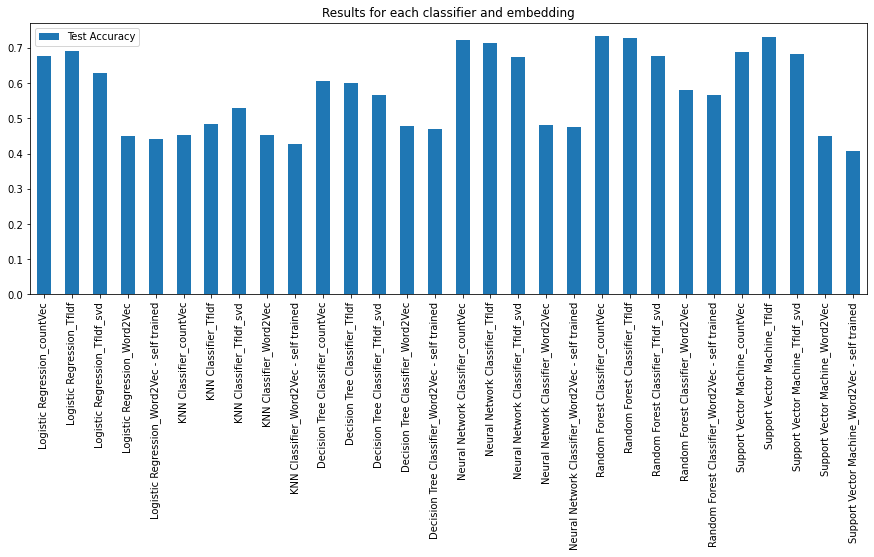

In [ ]:
fs_results = pd.DataFrame(list(test_accuracy), columns=["Test Accuracy"])
fs_results.index=index_names
fs_results  
fs_results.plot(kind="bar", title= "Results for each classifier and embedding",figsize=(15,5))

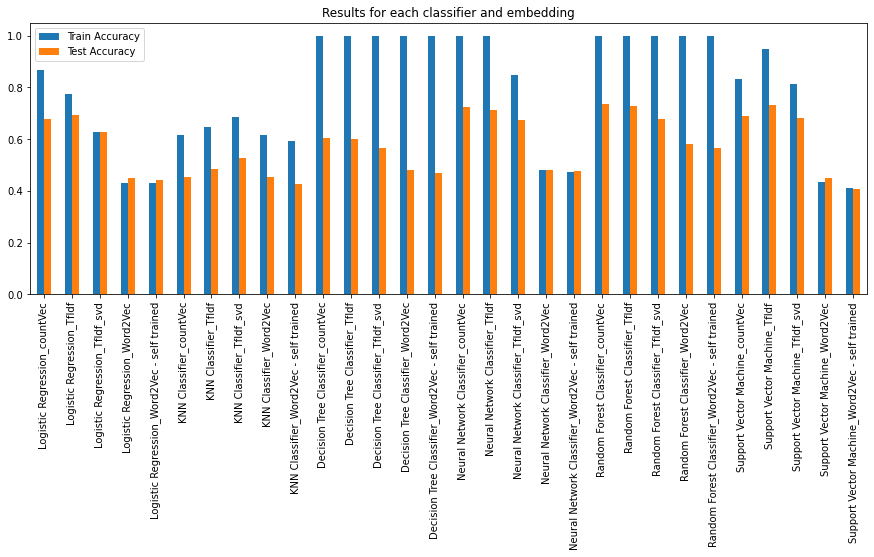

In [ ]:
fs_results.plot(kind="bar", title= "Results for each classifier and embedding",figsize=(15,5))

In [ ]:
#fs_results.to_excel('results.xlsx')

In [ ]:
fs_results.to_excel('results_complete.xlsx')

---
Amir Bachir

Pablo Laso